## **K MEANS**


K-Means es un algoritmo de clusterizacion que agrupa objetos en 'k' grupos basandose en caracteristicas, la finalidad en este trabajo es reducir el numero de colores de una imagen para disminuir su complejidad pero que aun mantenga la calidad visual.

 Iniciara generando 'k' puntos aleatorios en el espacio,los cuales seran nuestros centroides iniciales y luego se encuentran los puntos mas cercanos a estos centroides iniciales y se forman grupos. El valor promedio para cada grupo de convierte en el nuevo centroide y se repite el algoritmo hasta que nuestros centroides convergan y no se muevan de un umbral establecido, de caso contrario se dice que el algoritmo termino y se encontraron los 'k'.





In [1]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import random
import cv2 
from PIL import Image

In [2]:
random.seed(7)
np.random.seed(7)

**1)Seleccionamos un numero k aleatorio como centroides iniciales**

Definimos la funcion para obtener los centroides iniciales unicos, donde X corresponde a la matriz de datos de entrada, y k son el numero de centroides iniciales


In [3]:
def obtener_centroides_iniciales(X, k):
    
    numero_de_muestras = X.shape[0]
    ids_puntos_de_muestra = random.sample(range(0, numero_de_muestras), k)

    centroides = [tuple(X[id]) for id in ids_puntos_de_muestra]
    centroides_unicos = list(set(centroides))

    numero_de_centroides_unicos = len(centroides_unicos)

    while numero_de_centroides_unicos < k:
        nuevos_ids_puntos_de_muestra = random.sample(range(0, numero_de_muestras), k - numero_de_centroides_unicos)
        nuevos_centroides = [tuple(X[id]) for id in nuevos_ids_puntos_de_muestra]
        centroides_unicos = list(set(centroides_unicos + nuevos_centroides))

        numero_de_centroides_unicos = len(centroides_unicos)

    return np.array(centroides_unicos)

**2) Calculamos la distancia entre los puntos y los centroides mas cercanos**

Esta funcion calcula la distancia euclidiana entre las matrices A y B, y devuelve la matriz de distancias resultantes, esto mide la distancia de cada dato y el centroide mas cercano

In [4]:
def obtener_distancia_euclidiana(matriz_A, matriz_B):

    A_cuadrado = np.reshape(np.sum(matriz_A * matriz_A, axis=1), (matriz_A.shape[0], 1))
    B_cuadrado = np.reshape(np.sum(matriz_B * matriz_B, axis=1), (1, matriz_B.shape[0]))
    AB = matriz_A @ matriz_B.T

    C = -2 * AB + B_cuadrado + A_cuadrado

    return np.sqrt(C)

**3) Buscamos nuevos clusters y asignamos a centroide mas cercano**

La funcion obtener_clusters se utiliza para asignar punto de datos a los clusteres basandose en la distancia entre los puntos de datos y los centroides de los clusteres.


In [5]:
def obtener_clusters(X, centroides, metodo_medicion_distancia):

    k = centroides.shape[0]

    clusters = {}

    matriz_distancias = metodo_medicion_distancia(X, centroides)

    ids_cluster_mas_cercanos = np.argmin(matriz_distancias, axis=1)

    for i in range(k):
        clusters[i] = []

    for i, id_cluster in enumerate(ids_cluster_mas_cercanos):
        clusters[id_cluster].append(X[i])

    return clusters

**4)Verificamos si los centroides convergen**

Esta funcion se encarga de verificar si los centroides en una iteración han dejado de moverse significativamente en comparación con los centroides en la iteración actual, es decir si la distancia maxima entre los centroides antiguos y los nuevos es menos o igual al umbral especificado se asume que los centroides han convergido y el algoritmo se detiene.

In [6]:
def centroides_convergen(centroides_anteriores, centroides_nuevos, metodo_medicion_distancia, umbral_de_movimiento):

    distancias_entre_centroides_anteriores_y_nuevos = metodo_medicion_distancia(centroides_anteriores, centroides_nuevos)
    centroides_cubiertos = np.max(distancias_entre_centroides_anteriores_y_nuevos.diagonal()) <= umbral_de_movimiento

    return centroides_cubiertos

**5)Aplicamos K-means**

Ahora combinamos los pasos anteriores y aplicamos k-means , donde X es la matriz de datos de entrada en este caso una iamegn , k el numero de centroides a encontrar. Se aplica un bucle que se ejecuta hasta que centroides_cubiertos sea True lo que significa que los centroides se han estabilizado. En cada iteracion se guardan los centroides anteriores, se asignan los puntos de datos a los clusters mas cercanos , se calcuan nuevos clusters, se verifica si han convergido con la funcion centroides_cubiertos.

In [7]:
def k_means(X, k, metodo_medicion_distancia, umbral_de_movimiento=0):

    nuevos_centroides = obtener_centroides_iniciales(X=X, k=k)

    centroides_cubiertos = False

    while not centroides_cubiertos:
        centroides_anteriores = nuevos_centroides
        clusters = obtener_clusters(X, centroides_anteriores, metodo_medicion_distancia)

        nuevos_centroides = np.array([np.mean(clusters[key], axis=0, dtype=X.dtype) for key in sorted(clusters.keys())])

        centroides_cubiertos = centroides_convergen(centroides_anteriores, nuevos_centroides, metodo_medicion_distancia, umbral_de_movimiento)

    return nuevos_centroides

**6)Reducimos el numero de colores en una imagen**

Esta funcion devuelve una imagen con el numero especificado de colores reducidos , prrimero se obtiene la dimensionalidad de la imagen y se transforma a una matriz de 2D. Aplicamos k-means donde k son los numero de colores, se calcula la matriz de distancia entre los puntos y los centroides aplicados en K-means y se determina a que cluster (color) pertenece cada punto de datos. Luego de esto se recontruye la imagen con los colores reducidos utilizando los centroides encontrados en k-means donde cada punto de datos se toma el valor de su cluster mas cercano.


In [8]:
def imagen_con_colores_reducidos(imagen, numero_de_colores):

    h, w, d = imagen.shape

    X = np.reshape(imagen, (h * w, d))
    X = np.array(X, dtype=np.int32)

    centroides = k_means(X, k=numero_de_colores, metodo_medicion_distancia=obtener_distancia_euclidiana)
    matriz_distancias = obtener_distancia_euclidiana(X, centroides)
    ids_cluster_mas_cercanos = np.argmin(matriz_distancias, axis=1)

    X_reconstruida = centroides[ids_cluster_mas_cercanos]
    X_reconstruida = np.array(X_reconstruida, dtype=np.uint8)
    imagen_reducida = np.reshape(X_reconstruida, (h, w, d))

    return imagen_reducida

**7)Visualizacion**


Creamos un bucle donde se itera en cada uno de los valores de la lista valores_k , donde en cada iteracion se llama a la funcion imagen_con_colores_reducidos y el valor k para obtener la imagen con colores reducidos.

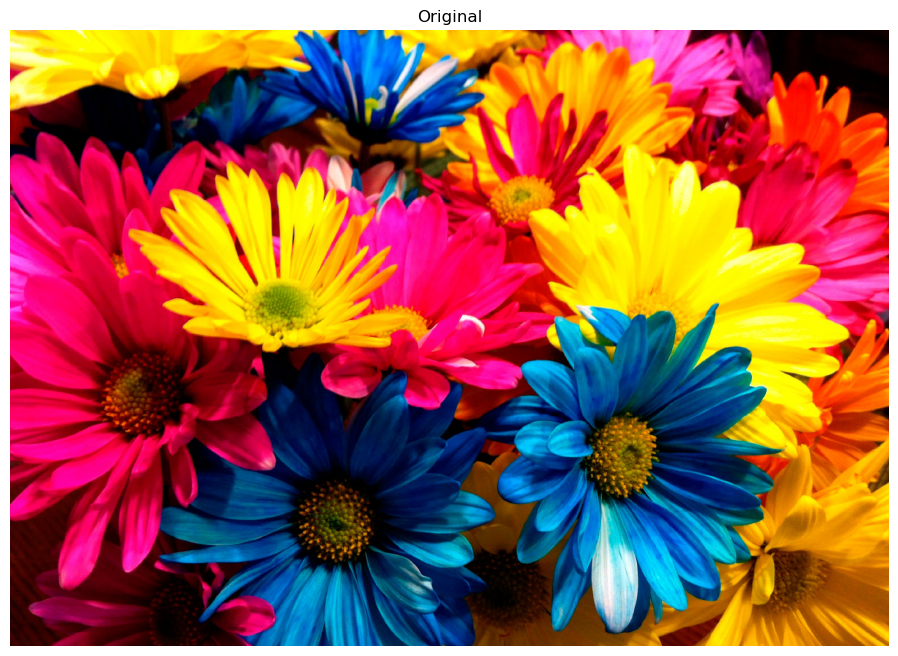

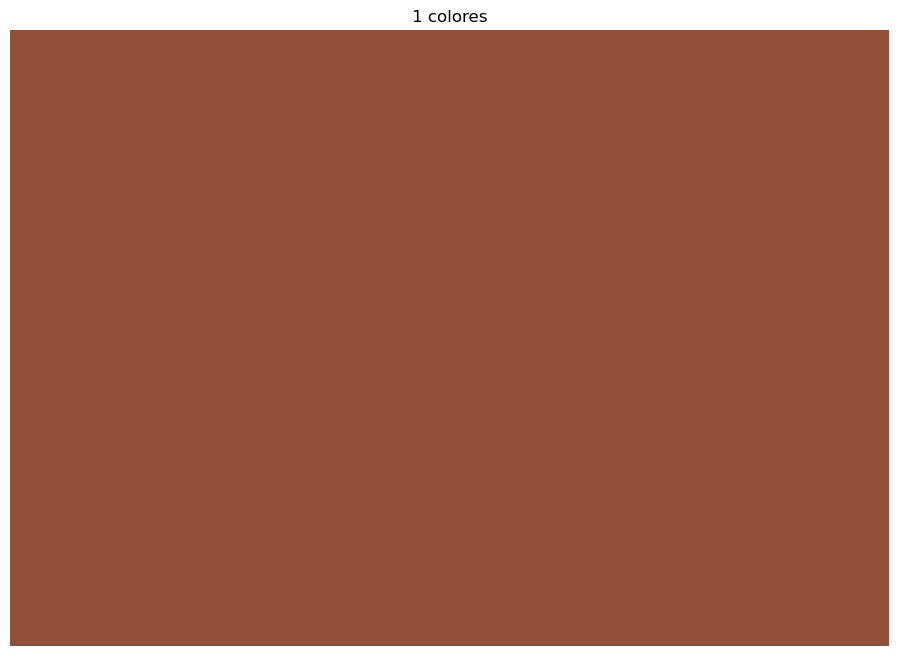

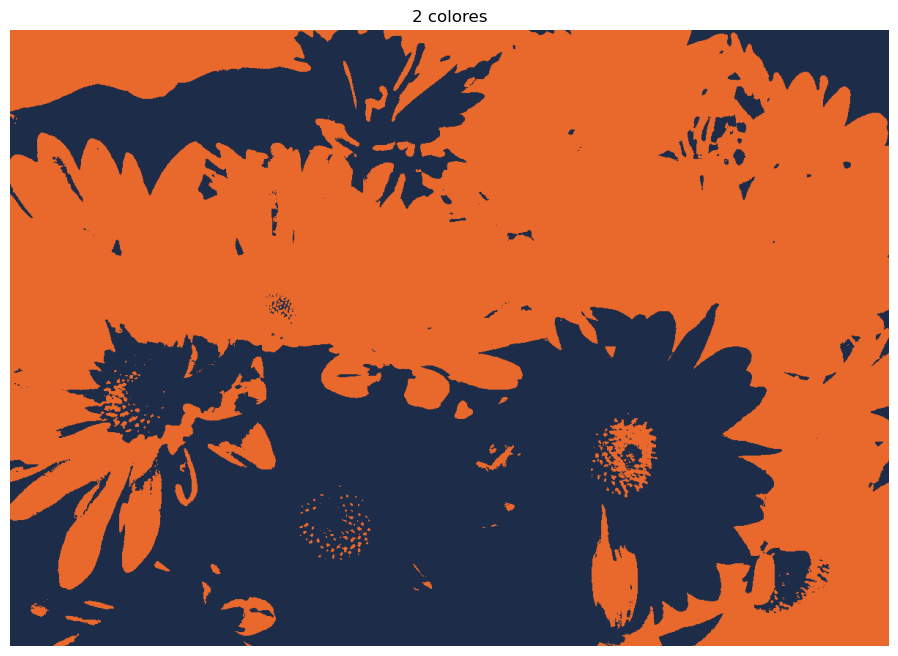

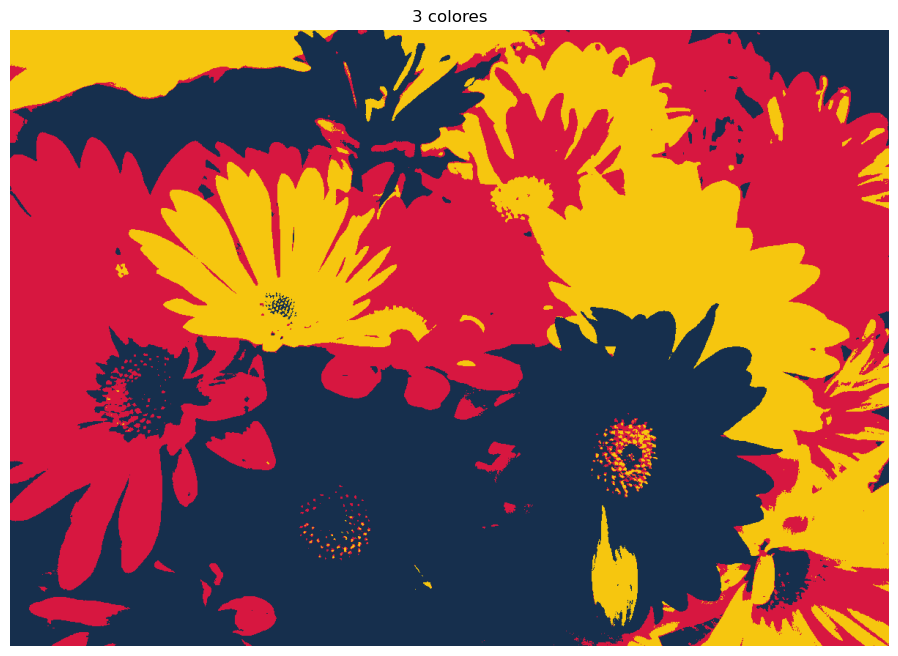

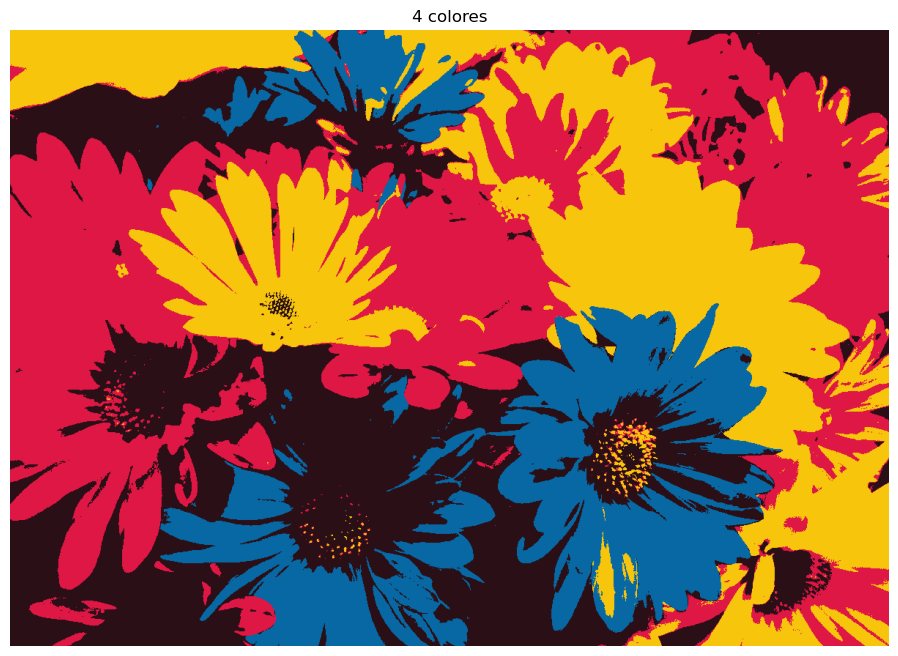

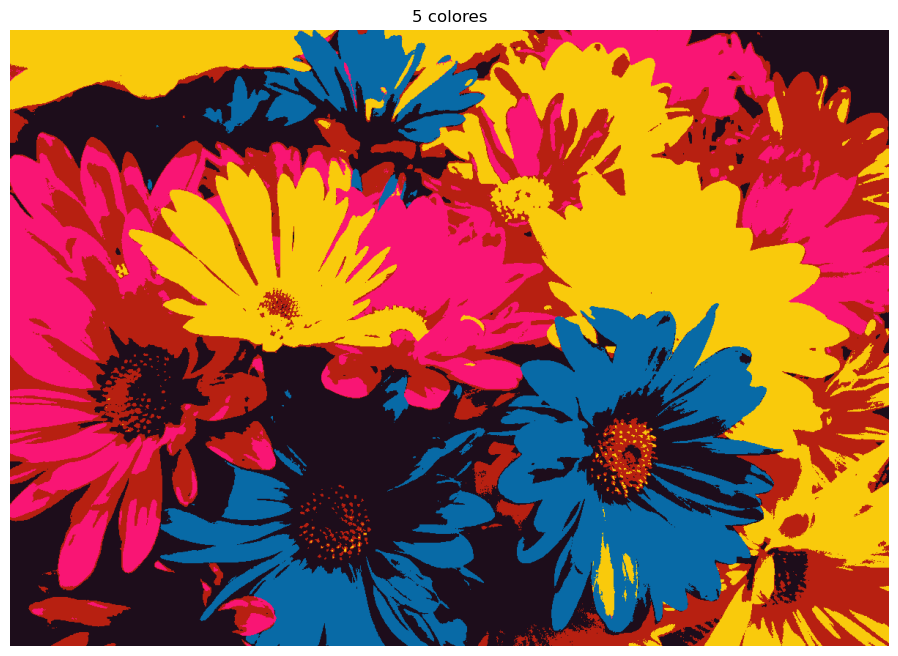

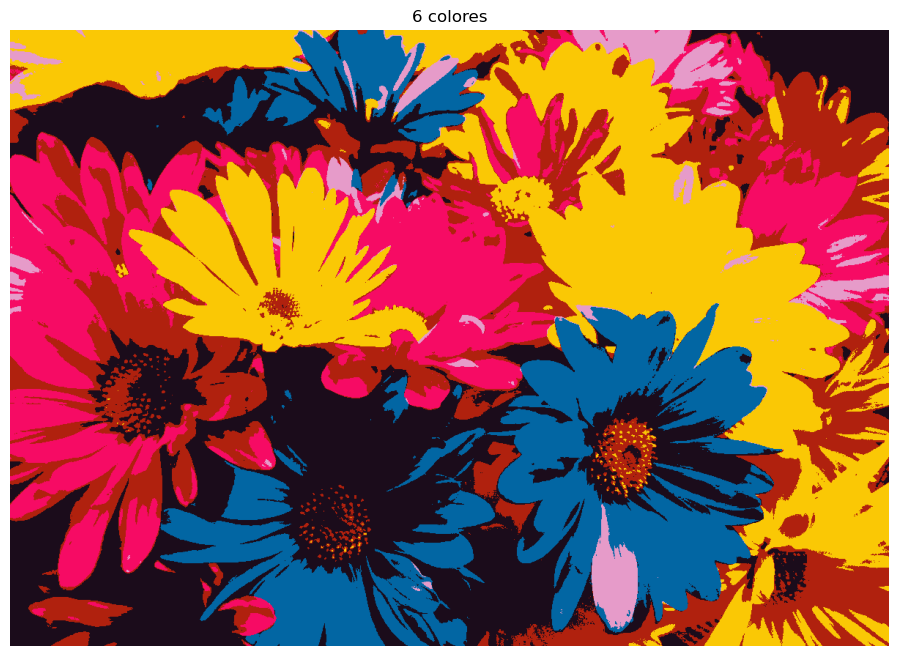

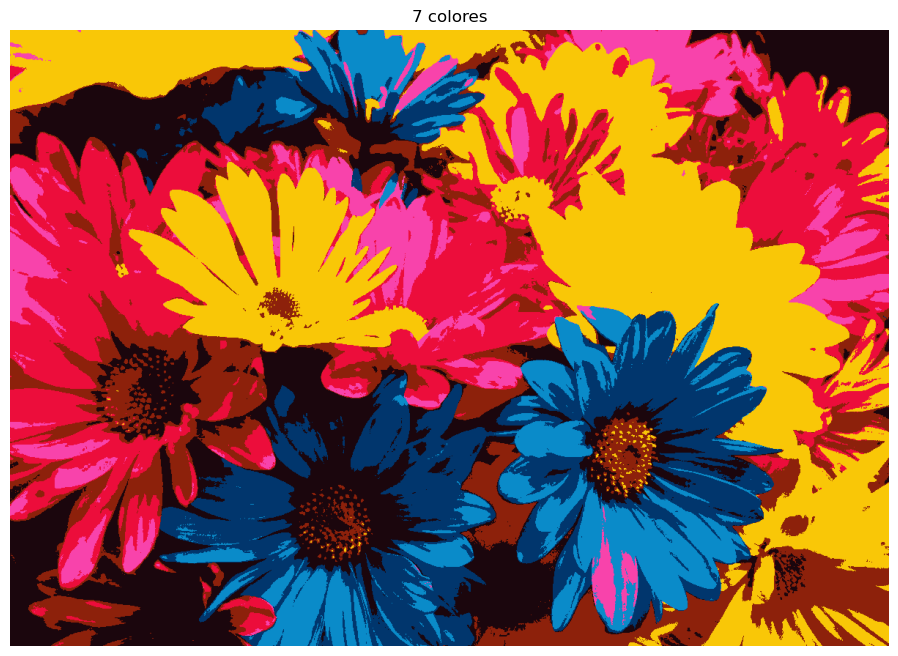

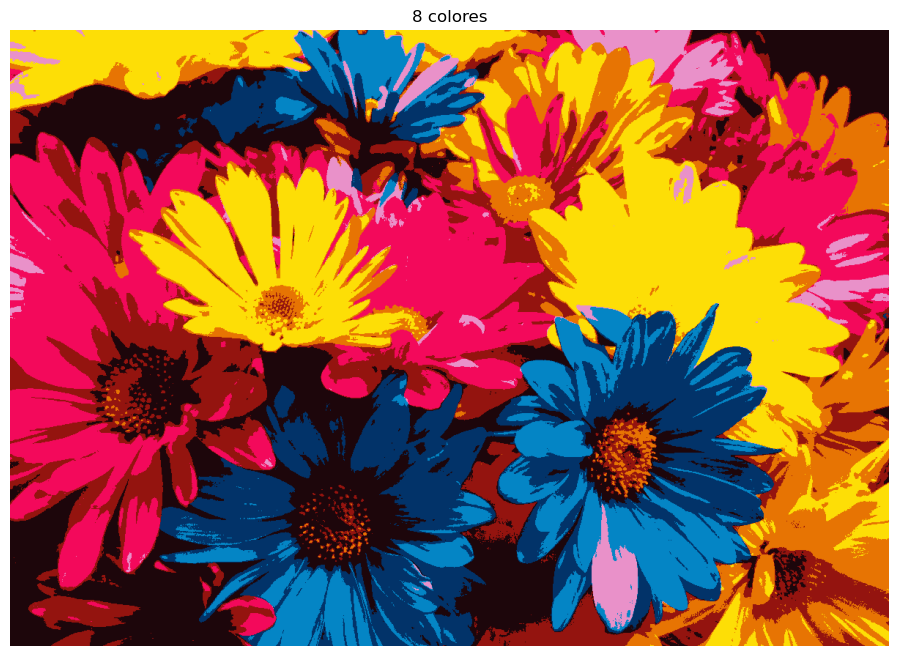

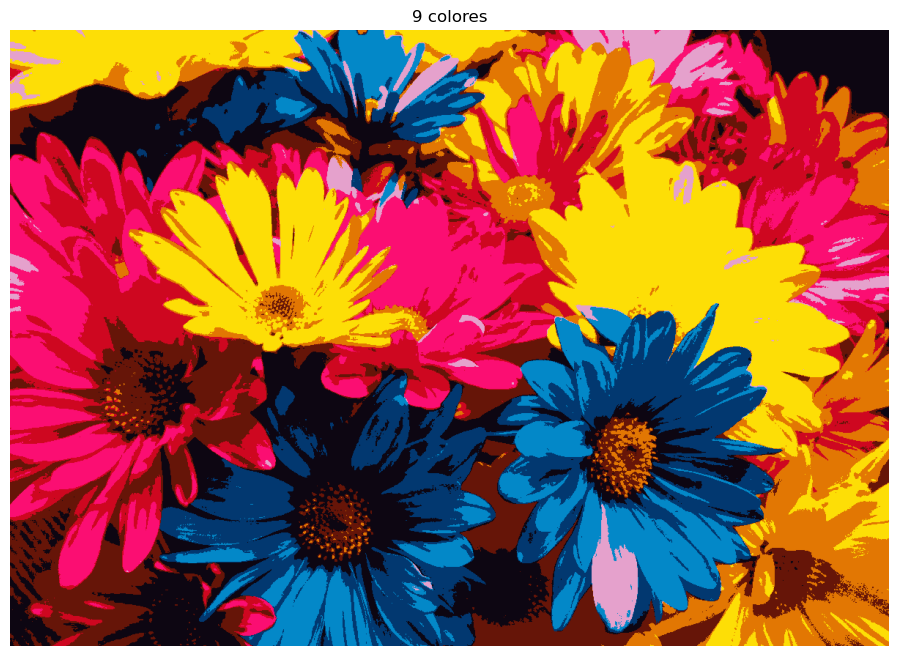

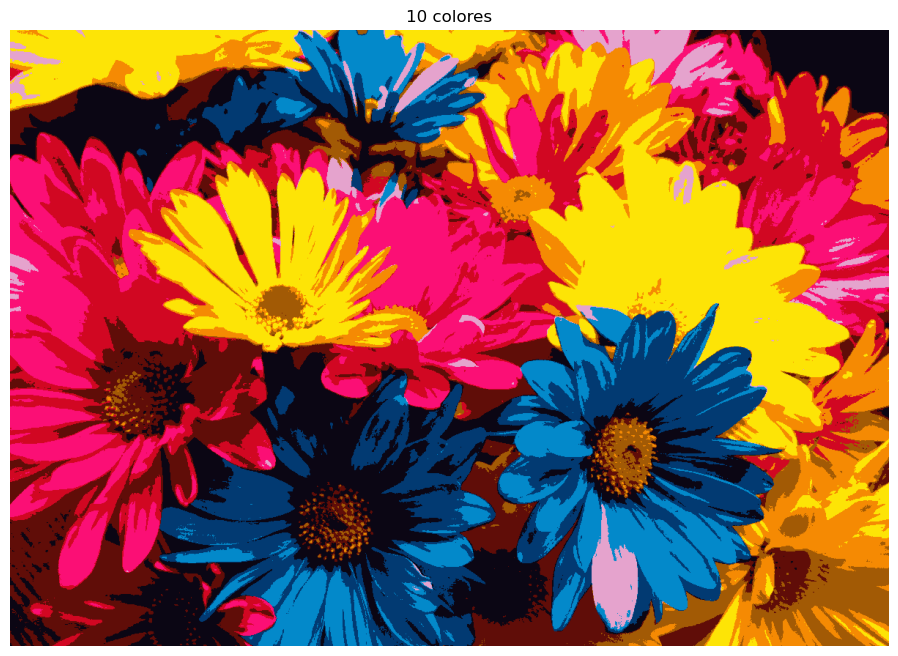

In [9]:
valores_k = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

reconstrucciones = []

imagen = cv2.imread("flores.png")
plt.rcParams['figure.figsize'] = [15, 8]
plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis('off')
plt.show()

for k in valores_k:
    imagen_colores_reducidos = imagen_con_colores_reducidos(imagen, k)
    plt.title(f"{k} colores")
    plt.axis('off')
    plt.imshow(cv2.cvtColor(imagen_colores_reducidos, cv2.COLOR_BGR2RGB))
    plt.show()
    reconstrucciones.append(imagen_colores_reducidos)

**8)Metodo del codo**

Generamos un grafico de linea con el fin de usar el metodo de codo para poder seleccionar la cantidad de k o clusteres a utilizar. El grafico muestra como varia la distorsion de la imagen en funcion del numero de colores utilizados. El objetivo con este grafico es poder identificar el punto donde existe un equilibrio entre la reduccion de la distorcion y la complejidad del modelo. Este metodo sirve para medir el rendimiento del algoritmo, fijandonos en la distorsion entre la original y las reconstrucciones.

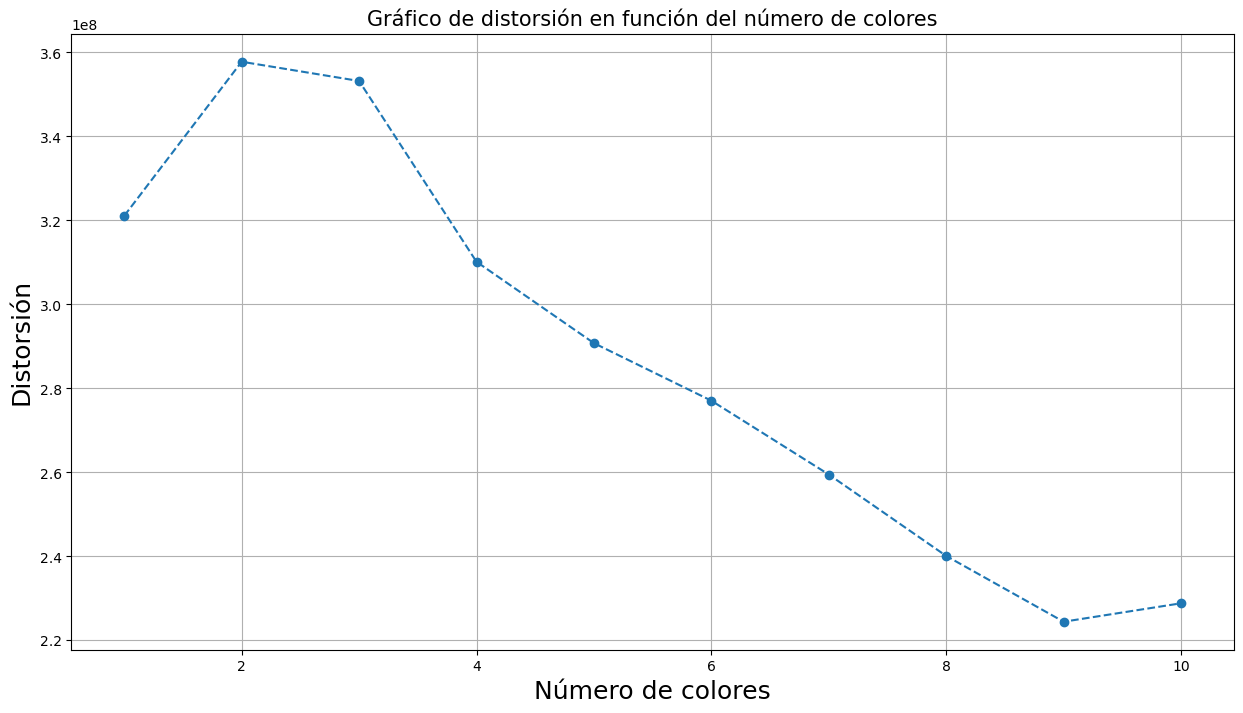

In [10]:
distorsiones = []
for i, k in enumerate(valores_k):
    distorsion = np.sum(np.square(imagen - reconstrucciones[i]))
    
    distorsiones.append(distorsion)
    
plt.grid()
plt.title("Gráfico de distorsión en función del número de colores", fontsize=15)
plt.xlabel('Número de colores', fontsize=18)
plt.ylabel('Distorsión', fontsize=18)
plt.plot(valores_k, distorsiones, linestyle='--', marker='o')
plt.show()

**9)Paleta de colores**

Con el finde observar que colores estamos utilizando desplegamos la paleta de colores. Podemos observar que los colores de las flores predominan mostrando una alta definición de sus formas y el café es usado para las sombras y lugares oscuro.

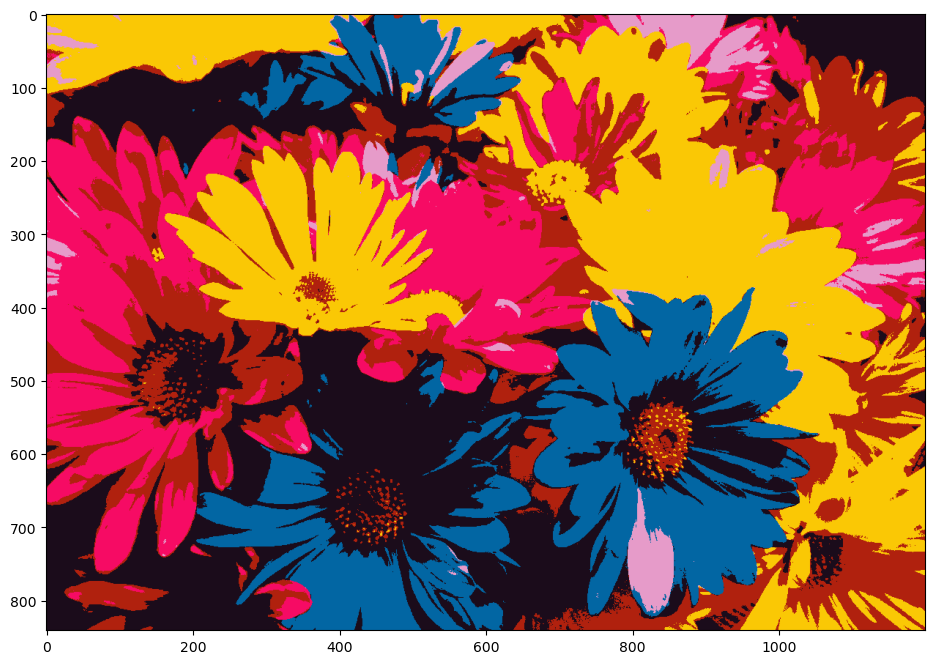

In [19]:
foto = reconstrucciones[5]
foto_bgr = foto[:, :, [2, 1, 0]]
#CAMBIO RGB POR BGR PARA PODER SER TRABAJADO 
plt.imshow(foto_bgr)

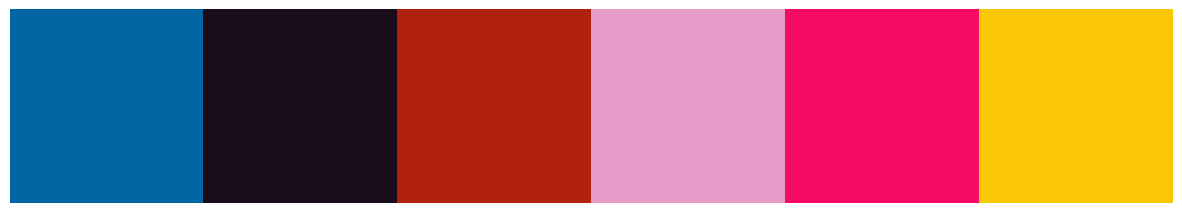

In [20]:
colores_unicos = np.unique(foto_bgr.reshape(-1, foto_bgr.shape[2]), axis=0)
paleta = Image.new('RGB', (len(colores_unicos), 1))

for i, color in enumerate(colores_unicos):
    paleta.putpixel((i, 0), tuple(color))

paleta.save('paleta_de_colores.png')
plt.imshow(paleta)
plt.axis('off') 
plt.show()


**9) Recomponemos la foto**

Recomponemos la imagen con la escala reducida de k=6, es decir solamente 6 colores.


(-0.5, 1199.5, 840.5, -0.5)

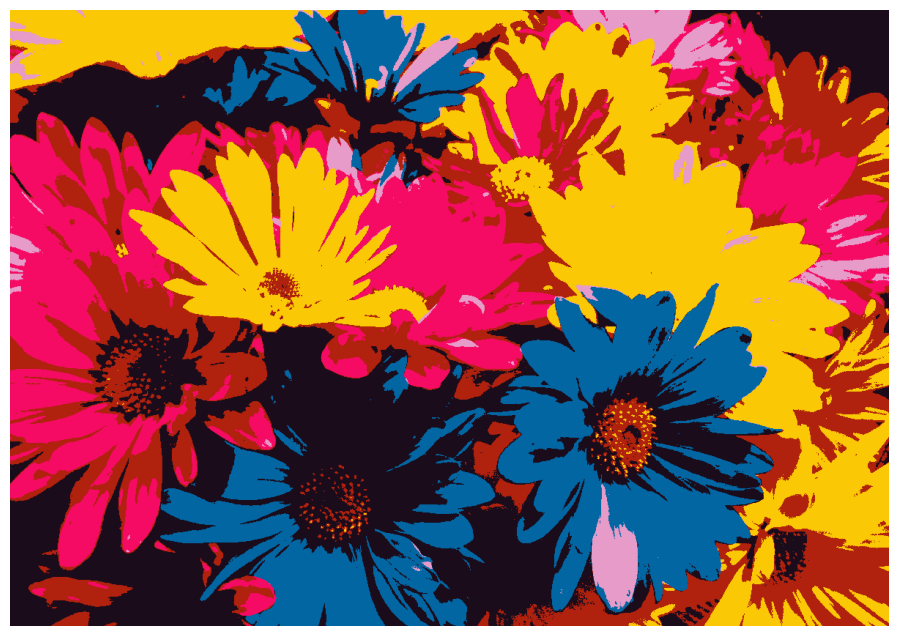

In [21]:
plt.imshow(foto_bgr)
plt.axis('off')

**Conclusion**

Pudimos demostrar la efectividad de K-Means para la reducción de colores de una imagen, resultando en una alta representación visual de la imagen y con un nivel de compresión significante. Este logaritmo es útil para la compresión de imágenes , la mejora en eficiencia de almacenamiento y transmisión de imágenes, e incluso en estilización de imágenes. Por otro lado es un logaritmo con limitaciones ya que cuando mas van aumentando los ‘k’ o colores de la imagen mas demora en ejecutar, por lo que en proyectos que se busca un  ‘k’ alto podría no ser lo más adecuado. También en imágenes que contienen colores muy similares puede presentar ciertas limitaciones debido a su forma de operar, como por ejemplo dividiendo colores que deberían agruparse juntos
